# Analysis script

Author: Lucien Bickerstaff @ MPI-BC tSCN

This script imports, processes, and plots the data for all modalities (light exposure, pupillary data, and subjective reporting)

In [1]:
# Import libraries 

import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # suppress future warnings
import pandas as pd
import numpy as np
import math
import scipy
from math import nan
import statistics as stat
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression

In [2]:
# Define functions

## Function to retrieve a small portion of an existing colourmap - to avoid very white and hard to see colours
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval), cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function to only return non-hidden files when running os.listdir()
def listdir_nohidden(path):
    return sorted(f for f in os.listdir(path) if not f.startswith('.'))

# Matplotlib settings

plt.rcParams['font.family'] = ['Arial'] # font settings
logscale = True # logarithmic scaling of axis

# Constants
n_trials = 24

{'10/08/2022': ['17:14'], '09/08/2022': ['18:23', '17:39', '14:13', '09:11'], '08/08/2022': ['17:44', '12:47', '10:04', '09:47', '09:07'], '05/08/2022': ['18:20', '17:42', '12:39', '09:14'], '04/08/2022': ['19:12', '17:42', '10:40', '10:10'], '03/08/2022': ['18:07', '12:31', '08:00'], '02/08/2022': ['13:03', '12:37', '09:35', '09:16', '08:55'], '01/08/2022': ['17:26', '09:33', '09:09'], '30/07/2022': ['19:17'], '29/07/2022': ['17:43', '12:47', '12:42'], '28/07/2022': ['13:09', '12:35', '09:55', '09:26'], '27/07/2022': ['16:57', '13:09', '09:27'], '26/07/2022': ['18:14', '12:36', '09:00'], '25/07/2022': ['12:46', '09:35', '09:31'], '24/07/2022': ['14:34', '12:49', '12:25'], '23/07/2022': ['16:28', '16:04', '15:54', '14:36', '13:57'], '22/07/2022': ['17:08', '13:13', '09:23', '08:54'], '21/07/2022': ['13:01', '09:02'], '20/07/2022': ['17:40', '15:41', '13:19', '09:30', '09:26', '08:54'], '19/07/2022': ['09:26', '08:58'], '18/07/2022': ['17:46', '09:22'], '17/07/2022': ['16:57', '16:08', 

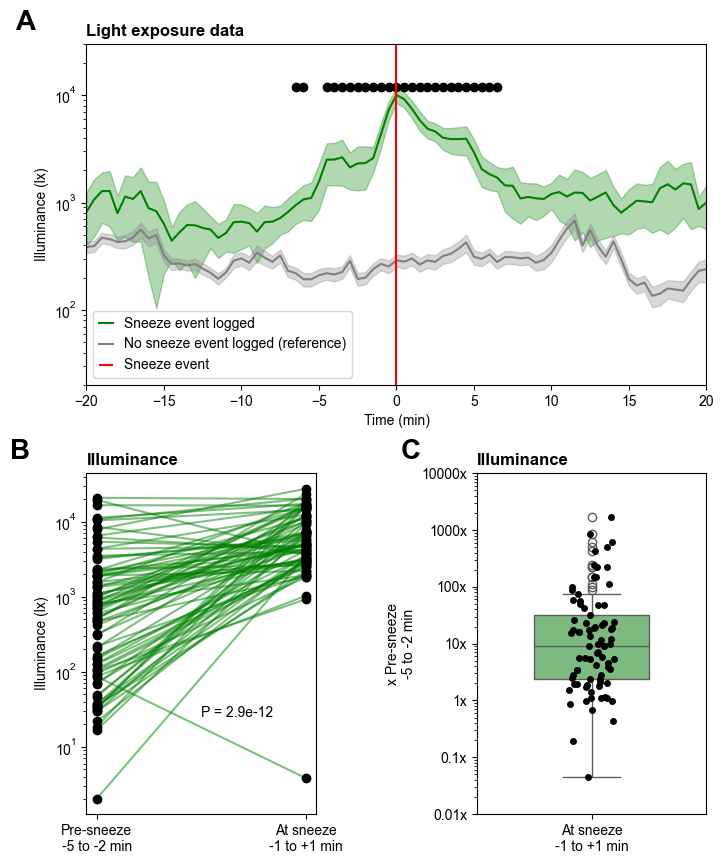

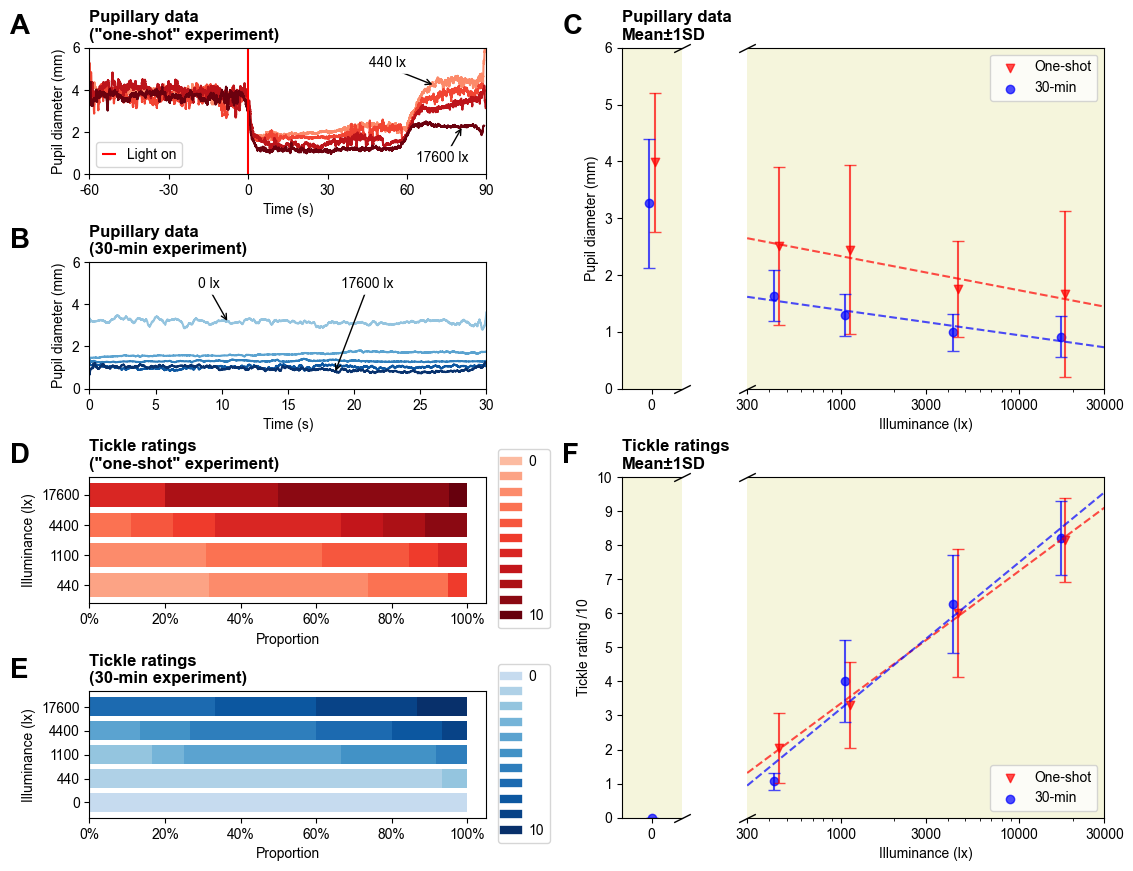

In [3]:
# Initialise seed
random.seed(4)

########################## GENERATING FIGURE 1 ##########################

fig1 = plt.figure(figsize=(8, 10))
gs1 = GridSpec(4, 2, figure = fig1, width_ratios=[0.5, 0.5])

# Subplots light data
axa = fig1.add_subplot(gs1[:-2, :])
axb = fig1.add_subplot(gs1[2:, 0])
axc = fig1.add_subplot(gs1[2:, 1])

# Margins between subplots
plt.subplots_adjust(wspace = 0.7, hspace=0.7)

########################## LIGHT DATA ##########################

chosen_n = 82

"""
Find timestamp of sneeze events from sneeze log in Notion
Plot average illuminance 20 min before and after this timestamp

Find timestamp of sneeze events from sneeze log in Notion
Use the timestamp as start for light data plotting
Calculate mean light levels pre-sneeze (-5 to -2 min) and at sneeze event (-1 to +1 min)
Plot categorically, to see step in light intensity before and at sneeze event
"""

# Opening combined light data file and creating a DataFrame
data = pd.read_csv('data/real_world_data/actiwatch_combined_data.txt', sep=';')
 
# Stripping DataFrame from unecessary data.
data = pd.DataFrame({'DATE/TIME': data['DATE/TIME'], 'LIGHT': data['LIGHT']})
 
# Sneeze event timestamps from exported Notion sneeze log
date_times = pd.read_csv('data/real_world_data/date_times_sneeze_log_notion.csv', sep = ';')
 
event_timestamps = {}
 
for row in date_times.iterrows():
    event_timestamps[row[1][0]]=[]
    # Creates keys with the date values
 
for row in date_times.iterrows():
    event_timestamps[row[1][0]].append(row[1][1])
    # Adds time values to the corresponding date / dict key
    
print(event_timestamps)
 
event_timestamps_list = []
 
for i in range(len(list(event_timestamps.items()))):
    for j in range(len(list(event_timestamps.items())[i][1])):
        event_timestamps_list.append(list(event_timestamps.items())[i][0]+' '+list(event_timestamps.items())[i][1][j])
 
n_sneeze = len(event_timestamps_list)     
 
event_timestamps_min = []
 
for e in event_timestamps_list:
    event_timestamps_min.append(int(e[11:-3])*60 + int(e[14:]))
 
lightdata = pd.DataFrame()
lightdata_calc_sneeze = pd.DataFrame()
 
# Create a new dataframe, add the light values for the desired range for each event
for i in range(n_sneeze):
    event_timestamp = event_timestamps_list[i]
    try:
        index_value = data[data['DATE/TIME'] == event_timestamp+':25']['LIGHT'].index.tolist()[0]
    except IndexError:
        try:
            index_value = data[data['DATE/TIME'] == event_timestamp+':18']['LIGHT'].index.tolist()[0]
        except IndexError:
            index_value = data[data['DATE/TIME'] == event_timestamp+':35']['LIGHT'].index.tolist()[0]
    lightdata[i] = data[index_value-40:index_value+41]['LIGHT'].tolist()
    
lightdata_sneeze_stat = lightdata
 
# Average
lightdata_calc_sneeze['average'] = lightdata.mean(1)

# Std
lightdata_calc_sneeze['std'] = lightdata.std(1)/math.sqrt(len(event_timestamps)) #SEM (= variance...)
 
# Plot average and shaded error bar
axa.plot(np.arange(-20,20.5,0.5), lightdata_calc_sneeze['average'], color='green', label='Sneeze event logged')
axa.fill_between(np.arange(-20,20.5,0.5), 
                 lightdata_calc_sneeze['average']-lightdata_calc_sneeze['std'], 
                 lightdata_calc_sneeze['average']+lightdata_calc_sneeze['std'],
                 facecolor='green',
                 color='green',
                 alpha=0.3)
 
#############################
 
'''
Plot light data when there was no sneeze on top
'''
 
no_sneeze_timestamps = []
 
n_no_sneeze = 1000 # Generating 1000 date & time values to be sure to have enough to work with
 
# while len(no_sneeze_timestamps) < sum([len(event_timestamps[x]) for x in event_timestamps if isinstance(event_timestamps[x], list)]):
while len(no_sneeze_timestamps) < n_no_sneeze:
    
    # Retrieving random date
    num = random.randrange(0, len(event_timestamps), 1)
    date = list(event_timestamps.items())[num][0]
    
    event_timestamps_min = []
    
    # Adding all timestamps within sneeze event for the randomly chosen date in a list of lists
    for e in event_timestamps[date]:
        event_timestamps_min.append(np.arange((int(e[:-3])*60 + int(e[3:]))-20, (int(e[:-3])*60 + int(e[3:]))+20, 1).tolist())
        
    # Merging all timestamps within one single list
    event_timestamps_min_merged = []
        
    # Getting rid of duplicates
    for e in event_timestamps_min:
        event_timestamps_min_merged+=e
        
    event_timestamps_min_merged = list(set(event_timestamps_min_merged))
    
    # Generating random hour and minute timestamp
    num = random.randrange(0, 1440, 1)
    
    rand_timestamps = list(range(num-15, num+15, 1)) # +- 15 min around timestamp
    hour = int(num/60)
    minute = num%60
    
    # Putting minute in right format
    if minute < 10:
        minute = '0'+str(minute)
    else:
        minute = str(minute)
    # Putting hour and date in right format
    if hour < 10:
        hour = '0'+str(hour)
    else:
        hour = str(hour)
    date = str(date)
    
    if int(hour) > 8 and int(hour) < 21: # If random timestamp within wearing time window
    
        if not any(item in rand_timestamps for item in event_timestamps_min_merged): # If random timstamp 30 min time window not in a sneeze event time window
            no_sneeze_timestamps.append(date+' '+hour+':'+minute)
        else:
            print(date+' '+hour+':'+minute+' = Within sneeze event window')
    else:
        print(date+' '+hour+':'+minute+' = Out of recording window')
 
no_sneeze_timestamps = sorted(no_sneeze_timestamps)
 
lightdata = pd.DataFrame()
lightdata_calc_no_sneeze = pd.DataFrame()
 
# Create a new dataframe, add the light values for the desired range for each event
n = 0
i = 0
while n < chosen_n :
    i+=1
    event_timestamp = no_sneeze_timestamps[i]
    try:
        index_value = data[data['DATE/TIME'] == event_timestamp+':25']['LIGHT'].index.tolist()[0]
        lightdata[str(n)+' - '+event_timestamp] = data[index_value-40:index_value+41]['LIGHT'].tolist()
    except IndexError:
        try:
            index_value = data[data['DATE/TIME'] == event_timestamp+':18']['LIGHT'].index.tolist()[0]
            lightdata[str(n)+' - '+event_timestamp] = data[index_value-40:index_value+41]['LIGHT'].tolist()
            n+=1
        except IndexError:
            try:
                index_value = data[data['DATE/TIME'] == event_timestamp+':35']['LIGHT'].index.tolist()[0]
                lightdata[str(n)+' - '+event_timestamp] = data[index_value-40:index_value+41]['LIGHT'].tolist()
                n+=1
            except IndexError:
                print(str(event_timestamp)+' = Index Error: date chosen out of recording')
              
lightdata_nosneeze_stat = lightdata
 
# Average
lightdata_calc_no_sneeze['average'] = lightdata.mean(1)

# Std
lightdata_calc_no_sneeze['std'] = lightdata.std(1)/math.sqrt(len(no_sneeze_timestamps)) #SEM (= variance...)
  
# Plot average and shaded error bar
axa.plot(np.arange(-20,20.5,0.5), lightdata_calc_no_sneeze['average'], color='grey', label='No sneeze event logged (reference)')
axa.fill_between(np.arange(-20,20.5,0.5), 
                 lightdata_calc_no_sneeze['average']-lightdata_calc_no_sneeze['std'], 
                 lightdata_calc_no_sneeze['average']+lightdata_calc_no_sneeze['std'],
                 facecolor='grey',
                 color='grey',
                 alpha=0.3)
 
# Plot parameters
if logscale:
    axa.vlines(0, ymin=0, ymax=30000, colors='r', label='Sneeze event')
    axa.set_yscale('log')
    axa.set_ylim(bottom=2e1, top=30000)
    axa.set_xlim(left=-20, right=20)
    axa.set_xlabel('Time (min)', fontsize=10)
    axa.set_ylabel('Illuminance (lx)', fontsize=10)
    axa.legend(loc='lower left', fontsize=10, handlelength = 1)
else:
    axa.vlines(0, ymin=0, ymax=12500, colors='r', label='Sneeze event')
    axa.ylim(bottom=2e1, top=12500)
    axa.xlim(left=-20, right=20)
    axa.xlabel('Time (min)', fontsize=10)
    axa.ylabel('Illuminance (lx)', fontsize=10)
    axa.legend(loc='lower left', fontsize=10, handlelength = 1)
    
##################### STATS

row_sneeze = []
for row in lightdata_sneeze_stat.iterrows():
    row_sneeze.append(list(row))
row_nosneeze = []
for row in lightdata_nosneeze_stat.iterrows():
    row_nosneeze.append(list(row))
    
stats = []
n_tests = 81

for i in range(n_tests):
    stats.append(scipy.stats.ttest_ind(row_sneeze[i][1], row_nosneeze[i][1]))
    
# Bonferroni correction
p_value_threshold = 0.05 / n_tests

for i in range(n_tests):
    if stats[i][1] < p_value_threshold:
        axa.scatter(i/2-20, 12000, color='k')
        
'''
Secondary plots
'''

# Pre-sneeze
lightdata_presneeze = pd.DataFrame()
# Create a new dataframe, add the light values for the desired range for each event
for i in range(len(event_timestamps_list)):
    event_timestamp = event_timestamps_list[i]
    try:
        index_value = data[data['DATE/TIME'] == event_timestamp+':25']['LIGHT'].index.tolist()[0]
    except IndexError:
        try:
            index_value = data[data['DATE/TIME'] == event_timestamp+':18']['LIGHT'].index.tolist()[0]
        except IndexError:
            index_value = data[data['DATE/TIME'] == event_timestamp+':35']['LIGHT'].index.tolist()[0]
        
    lightdata_presneeze[i] = data[index_value-10:index_value-4]['LIGHT'].tolist() #-10 = -5 min, -4 = -2 min
# Average
lightdata_presneeze_mean = []
for i in range(len(event_timestamps_list)):
    lightdata_presneeze_mean.append(np.nanmean(lightdata_presneeze[i]))


# At sneeze
lightdata_atsneeze = pd.DataFrame()
# Create a new dataframe, add the light values for the desired range for each event
for i in range(len(event_timestamps_list)):
    event_timestamp = event_timestamps_list[i]
    try:
        index_value = data[data['DATE/TIME'] == event_timestamp+':25']['LIGHT'].index.tolist()[0]
    except IndexError:
        try:
            index_value = data[data['DATE/TIME'] == event_timestamp+':18']['LIGHT'].index.tolist()[0]
        except IndexError:
            index_value = data[data['DATE/TIME'] == event_timestamp+':35']['LIGHT'].index.tolist()[0]
    lightdata_atsneeze[i] = data[index_value-2:index_value+2]['LIGHT'].tolist() #-2 = -1 min, +2 = +1 min
# Average
lightdata_atsneeze_mean = []
for i in range(len(event_timestamps_list)):
    lightdata_atsneeze_mean.append(np.nanmean(lightdata_atsneeze[i]))

# Median instead…
# lightdata_presneeze_median = []
# for i in range(len(event_timestamps_list)):
#     lightdata_presneeze_median.append(np.nanmedian(lightdata_presneeze[i]))
# lightdata_atsneeze_median = []
# for i in range(len(event_timestamps_list)):
#     lightdata_atsneeze_median.append(np.nanmedian(lightdata_atsneeze[i]))

x = ['Pre-sneeze\n-5 to -2 min', 'At sneeze\n-1 to +1 min']

# Plot mean and shaded error bar
axb.plot(x, [lightdata_presneeze_mean, lightdata_atsneeze_mean], color='green', alpha=0.5)
axb.plot(x, [lightdata_presneeze_mean, lightdata_atsneeze_mean], 'ko')
axb.set_yticks([1e1, 1e2, 1e3, 1e4], labels=['10', '100', '1000', '10000'])
axb.set_yscale('log')
axb.set_ylabel('Illuminance (lx)', fontsize=10)

# Contrast
lightdata_presneeze_mean_percent = []
lightdata_atsneeze_mean_percent = []

for i in range(len(event_timestamps_list)):
    lightdata_presneeze_mean_percent.append(lightdata_presneeze_mean[i]/lightdata_presneeze_mean[i]*100)
    lightdata_atsneeze_mean_percent.append(lightdata_atsneeze_mean[i]/lightdata_presneeze_mean[i]*100)
# for i in range(len(event_timestamps_list)):
#     lightdata_presneeze_mean_percent.append(lightdata_presneeze_median[i]/lightdata_presneeze_median[i]*100)
#     lightdata_atsneeze_mean_percent.append(lightdata_atsneeze_median[i]/lightdata_presneeze_median[i]*100)


# Recreating DataFrame from the two lists from plotting afterwards
zipped = list(zip(lightdata_presneeze_mean_percent, lightdata_atsneeze_mean_percent))
df = pd.DataFrame(zipped, columns = x)

# Dropping 13th value = 86 000 %
df = df.drop(index=13)

# Dropping Pre-sneeze data (might be useful to keep the somewhere if needed)
df2 = df.drop(['Pre-sneeze\n-5 to -2 min'], axis=1)

sns.stripplot(data = df2/100, color='black', ax=axc)
sns.boxplot(data = df2/100, width=0.5, palette='Greens', ax=axc)
axc.set_ylabel('x Pre-sneeze\n-5 to -2 min', fontsize=10)
axc.set_yscale('log')
axc.set_yticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], labels=['0.01x', '0.1x', '1x', '10x', '100x', '1000x', '10000x'])

# Stats
stats = scipy.stats.ttest_rel(lightdata_presneeze_mean, lightdata_atsneeze_mean)
p_value = round(stats[1], 13)
axb.text(.5, 25, 'P = '+str(p_value), fontsize=10)

# Titles
axa.set_title('Light exposure data', loc='left', fontweight='bold')
axb.set_title('Illuminance', loc='left', fontweight='bold')
axc.set_title('Illuminance', loc='left', fontweight='bold')


# Panel labels (Figure 1)
axa.annotate('A', xy=(-0.113, 1.1), xycoords='axes fraction', size=20, weight='bold', va='top')
axb.annotate('B', xy=(-0.333, 1.1), xycoords='axes fraction', size=20, weight='bold', va='top')
axc.annotate('C', xy=(-0.333, 1.1), xycoords='axes fraction', size=20, weight='bold', va='top')

# Make sure the plots folder exists
os.makedirs("outputs", exist_ok=True)
# Save plot
plt.savefig('outputs/figure1.pdf')
plt.savefig(
    "outputs/figure1.tiff",
    format="tiff",
    dpi=600,              # 300–600 dpi is typical for journals
    bbox_inches="tight",  # removes extra whitespace
    pil_kwargs={"compression": "tiff_lzw"}  # lossless compression
)

########################## GENERATING FIGURE 2 ##########################

fig2 = plt.figure(figsize=(14, 10))
gs2 = GridSpec(4, 3, figure = fig2, width_ratios=[1, 0.15, 0.9])
gs2.update(wspace=0.5)

# Subplots pupil & tickle data
ax2 = fig2.add_subplot(gs2[0, 0])
ax3 = fig2.add_subplot(gs2[1, 0])
ax4 = fig2.add_subplot(gs2[:-2, 1])
ax5 = fig2.add_subplot(gs2[:-2, 2])
ax7 = fig2.add_subplot(gs2[2, 0])
ax8 = fig2.add_subplot(gs2[3, 0])
ax9 = fig2.add_subplot(gs2[2:, 1])
ax10 = fig2.add_subplot(gs2[2:, 2])

# Margins between subplots
plt.subplots_adjust(wspace = 0.7, hspace=0.7)

########################## PUPIL RAW ########################## 

# One-shot

conf = 0.7
moving_average_window = 40

# Specifying path
path = 'data/lab_data/one_shot_exp/'
dirs = listdir_nohidden(path)
dirs.pop(25) # minus trial 25 which doesn't have sneeze data for some reason
dirs.pop(52) # minus trial 53 which doesn't have sneeze data for some reason

data_60 = pd.DataFrame()
data_150 = pd.DataFrame()
data_600 = pd.DataFrame()
data_2400 = pd.DataFrame()

num = 0

for i in dirs:
    num += 1
    # Opening csv files
    data = pd.read_csv(path+str(i)+'/exports/000/pupil_positions.csv')
    annotations = pd.read_csv(path+str(i)+'/exports/000/annotations.csv')
    info = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')
    
    # Apply confidence threshold on pupil diameter values
    data['diameter_3d'].mask(data['confidence']<conf, other = nan, inplace = True)
               
    # Stripping DataFrame from unecessary data. Converting timestamps in min and normalising to light onset = 0 min
    data = pd.DataFrame({'pupil_timestamp': data['pupil_timestamp']/60-annotations.timestamp[annotations['label']=='lights on'].to_list()[0]/60,
                         'diameter_3d': data['diameter_3d']})
    
    # Getting rid of diameter values where timestamp is under -1 or over +1.5
    data = data.mask((-1>data['pupil_timestamp']) | (data['pupil_timestamp']>1.5), other = 'trash') # labelling unwanted values as 'trash'
    data.drop(index=data[data['pupil_timestamp'] == 'trash'].index, inplace = True) # getting rid of them
    data = data.reset_index(drop=True) # resetting index to 0
    
    if (info['setting'] == 60)[0]:
        data_60 = pd.concat([data_60, data['diameter_3d']], axis = 1)
    elif (info['setting'] == 150)[0]:
        data_150 = pd.concat([data_150, data['diameter_3d']], axis = 1)
    elif (info['setting'] == 600)[0]:
        data_600 = pd.concat([data_600, data['diameter_3d']], axis = 1)
    elif (info['setting'] == 2400)[0]:
        data_2400 = pd.concat([data_2400, data['diameter_3d']], axis = 1)
    else:
        print('error')
        
    print(str(num)+'/'+str(len(dirs)))

# Filling DataFrame
average_data = pd.DataFrame()
average_data['60 mean'] = data_60.mean(1)
average_data['60 std'] = data_60.std(1)
average_data['150 mean'] = data_150.mean(1)
average_data['150 std'] = data_150.std(1)
average_data['600 mean'] = data_600.mean(1)
average_data['600 std'] = data_600.std(1)
average_data['2400 mean'] = data_2400.mean(1)
average_data['2400 std'] = data_2400.std(1)

cmap = plt.get_cmap('Reds')

# Moving average
average_data['60 mean'] = average_data['60 mean'].rolling(window=moving_average_window, min_periods=2).mean()
average_data['150 mean'] = average_data['150 mean'].rolling(window=moving_average_window, min_periods=2).mean()
average_data['600 mean'] = average_data['600 mean'].rolling(window=moving_average_window, min_periods=2).mean()
average_data['2400 mean'] = average_data['2400 mean'].rolling(window=moving_average_window, min_periods=2).mean()

# Plotting
ax2.plot(average_data['60 mean'], color = cmap(0.4))
ax2.plot(average_data['150 mean'], color = cmap(0.6))
ax2.plot(average_data['600 mean'], color = cmap(0.8))
ax2.plot(average_data['2400 mean'], color = cmap(0.99))

# Plot parameters
ax2.set_xticks(ticks = [0, 
round(len(average_data.index)/5), 
round(len(average_data.index)/5)*2,
round(len(average_data.index)/5)*3,
round(len(average_data.index)/5)*4,
len(average_data.index)], labels = ['-60', '-30', '0', '30', '60', '90'])
ax2.set_ylabel('Pupil diameter (mm)', fontsize=10)
ax2.set_xlabel('Time (s)', fontsize=10)
ax2.set_xlim(left=0, right=len(average_data.index))
ax2.set_ylim(bottom=0, top=6)
ax2.vlines(round(len(average_data.index)/5)*2, ymin=0, ymax=10, colors='red', label='Light on')

ax2.legend(loc='lower left', fontsize = 10, handlelength = 1)

# 30-min exp

# Specifying path
path = 'data/lab_data/30_min_exp/'
dirs = listdir_nohidden(path)

data_0 = pd.DataFrame()
data_60 = pd.DataFrame()
data_150 = pd.DataFrame()
data_600 = pd.DataFrame()
data_2400 = pd.DataFrame()

num = 0

for i in dirs:
    
    num += 1
    
    print('######### '+str(num)+'/'+str(len(dirs))+' #########')
    
    # Opening csv files
    data = pd.read_csv(path+str(i)+'/exports/000/pupil_positions.csv')
    annotations = pd.read_csv(path+str(i)+'/exports/000/annotations.csv')
    info = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')
    
    annotations_timestamps = annotations.timestamp[annotations['label']=='lights on'].to_list()
    
    # Apply confidence threshold on pupil diameter values
    data['diameter_3d'].mask(data['confidence']<conf, other = nan, inplace = True)
    
    setting_list = info['setting'][0][1:-1].split(', ')
    
    for j in range(n_trials):
        
        annotation_timestamp = annotations_timestamps[j]
                        
        # Stripping DataFrame from unecessary data. Converting timestamps in min and normalising to light onset = 0 min
        data_temp = pd.DataFrame({'pupil_timestamp': data['pupil_timestamp']/60-annotation_timestamp/60,
                             'diameter_3d': data['diameter_3d']})
        
        # Getting rid of diameter values where timestamp is under -1 or over +1.5
        data_temp = data_temp.mask((0.05>data_temp['pupil_timestamp']) | (data_temp['pupil_timestamp']>0.55), other = 'trash') # labelling unwanted values as 'trash'
        data_temp.drop(index=data_temp[data_temp['pupil_timestamp'] == 'trash'].index, inplace = True) # getting rid of them
        data_temp = data_temp.reset_index(drop=True) # resetting index to 0
        
        if (setting_list[j] == '-2'):
            data_0 = pd.concat([data_0, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '-1'):
            data_60 = pd.concat([data_60, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '0'):
            data_150 = pd.concat([data_150, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '1'):
            data_600 = pd.concat([data_600, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '2'):
            data_2400 = pd.concat([data_2400, data_temp['diameter_3d']], axis = 1)
        else:
            print('error')
        
        print(str(j+1)+'/'+str(n_trials))                      
              
# Filling DataFrame
average_data = pd.DataFrame()
average_data['0 mean'] = data_0.mean(1)
average_data['0 std'] = data_0.std(1)
average_data['60 mean'] = data_60.mean(1)
average_data['60 std'] = data_60.std(1)
average_data['150 mean'] = data_150.mean(1)
average_data['150 std'] = data_150.std(1)
average_data['600 mean'] = data_600.mean(1)
average_data['600 std'] = data_600.std(1)
average_data['2400 mean'] = data_2400.mean(1)
average_data['2400 std'] = data_2400.std(1)

cmap = plt.get_cmap('Blues')

# Moving average
average_data['0 mean'] = average_data['0 mean'].rolling(window=moving_average_window, min_periods=2).mean()
average_data['60 mean'] = average_data['60 mean'].rolling(window=moving_average_window, min_periods=2).mean()
average_data['150 mean'] = average_data['150 mean'].rolling(window=moving_average_window, min_periods=2).mean()
average_data['600 mean'] = average_data['600 mean'].rolling(window=moving_average_window, min_periods=2).mean()
average_data['2400 mean'] = average_data['2400 mean'].rolling(window=moving_average_window, min_periods=2).mean()

# Plotting
ax3.plot(average_data['0 mean'], color = cmap(0.4))
ax3.plot(average_data['60 mean'], color = cmap(0.55))
ax3.plot(average_data['150 mean'], color = cmap(0.7))
ax3.plot(average_data['600 mean'], color = cmap(0.85))
ax3.plot(average_data['2400 mean'], color = cmap(0.99))

# Plot parameters
ax3.set_xticks(ticks = [0, 
round(len(average_data.index)/6), 
round(len(average_data.index)/6)*2,
round(len(average_data.index)/6)*3,
round(len(average_data.index)/6)*4,
round(len(average_data.index)/6)*5,
len(average_data.index)], labels = ['0', '5', '10', '15', '20', '25', '30'])
ax3.set_xlabel('Time (s)', fontsize=10)
ax3.set_ylabel('Pupil diameter (mm)', fontsize=10)
ax3.set_xlim(left=0, right=len(average_data.index))
ax3.set_ylim(bottom=0, top=6)

# Arrows and text boxes

arrow_props1 = dict(facecolor = 'black', edgecolor = 'black', arrowstyle = '->')
ax2.annotate('', xy = (33500, 2.3), xytext = (0.89, 0.1), transform = ax2.transAxes, textcoords = 'axes fraction', arrowprops = arrow_props1)

text_box1 = dict(boxstyle = 'round', facecolor='white', alpha = 1, edgecolor = 'none')
ax2.text(0.89, 0.1, '17600 lx', transform = ax2.transAxes, fontsize = 10, bbox = text_box1, ha = 'center')

arrow_props2 = dict(facecolor = 'black', edgecolor = 'black', arrowstyle = '->')
ax2.annotate('', xy = (31000, 4.2), xytext = (0.75, 0.85), transform = ax2.transAxes, textcoords = 'axes fraction', arrowprops = arrow_props2)

text_box2 = dict(boxstyle = 'round', facecolor='white', alpha = 1, edgecolor = 'none')
ax2.text(0.75, 0.85, '440 lx', transform = ax2.transAxes, fontsize = 10, bbox = text_box2, ha = 'center')

##

arrow_props3 = dict(facecolor = 'black', edgecolor = 'black', arrowstyle = '->')
ax3.annotate('', xy = (4400, 0.7), xytext = (0.7, 0.8), transform = ax3.transAxes, textcoords = 'axes fraction', arrowprops = arrow_props3)

text_box3 = dict(boxstyle = 'round', facecolor='white', alpha = 1, edgecolor = 'none')
ax3.text(0.7, 0.8, '17600 lx', transform = ax3.transAxes, fontsize = 10, bbox = text_box3, ha = 'center')

arrow_props4 = dict(facecolor = 'black', edgecolor = 'black', arrowstyle = '->')
ax3.annotate('', xy = (2500, 3.1), xytext = (0.3, 0.8), transform = ax3.transAxes, textcoords = 'axes fraction', arrowprops = arrow_props4)

text_box4 = dict(boxstyle = 'round', facecolor='white', alpha = 1, edgecolor = 'none')
ax3.text(0.3, 0.8, '0 lx', transform = ax3.transAxes, fontsize = 10, bbox = text_box4, ha = 'center')

##

# Final touches
ax2.set_title('Pupillary data\n("one-shot" experiment)', loc='left', fontweight='bold')
ax3.set_title('Pupillary data\n(30-min experiment)', loc='left', fontweight='bold')

########################## PUPIL AVERAGE ##########################

# One shot

# Specifying path
path = 'data/lab_data/one_shot_exp/'
dirs = listdir_nohidden(path)
dirs.pop(25) # minus trial 25 which doesn't have sneeze data for some reason
dirs.pop(52) # minus trial 53 which doesn't have sneeze data for some reason

data_0 = pd.DataFrame()
data_60 = pd.DataFrame()
data_150 = pd.DataFrame()
data_600 = pd.DataFrame()
data_2400 = pd.DataFrame()

num = 0

for i in dirs:
    num += 1
    # Opening csv files
    data = pd.read_csv(path+str(i)+'/exports/000/pupil_positions.csv')
    annotations = pd.read_csv(path+str(i)+'/exports/000/annotations.csv')
    info = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')
    
    # Apply confidence threshold on pupil diameter values
    data['diameter_3d'].mask(data['confidence']<conf, other = nan, inplace = True)
               
    # Stripping DataFrame from unecessary data. Converting timestamps in min and normalising to light onset = 0 min
    data = pd.DataFrame({'pupil_timestamp': data['pupil_timestamp']/60-annotations['timestamp'][0]/60, 'diameter_3d': data['diameter_3d']})
    
    # Getting rid of diameter values where timestamp is under -1 or over 0 (= keep last minute of dark period):
    data_off = data.mask((-1>data['pupil_timestamp']) | (data['pupil_timestamp']>0), other = 'trash') # labelling unwanted values as 'trash'
    data_off.drop(index=data_off[data_off['pupil_timestamp'] == 'trash'].index, inplace = True) # getting rid of them
    data_off = data_off.reset_index(drop=True) # resetting index to 0
    
    data_0 = pd.concat([data_0, data_off['diameter_3d']], axis = 1)
    
    # Getting rid of diameter values where timestamp is under 0.25 or over 0.75 (= keep plateau):
    data_on = data.mask((0.25>data['pupil_timestamp']) | (data['pupil_timestamp']>0.75), other = 'trash') # labelling unwanted values as 'trash'
    data_on.drop(index=data_on[data_on['pupil_timestamp'] == 'trash'].index, inplace = True) # getting rid of them
    data_on = data_on.reset_index(drop=True) # resetting index to 0
    
    if (info['setting'] == 60)[0]:
        data_60 = pd.concat([data_60, data_on['diameter_3d']], axis = 1)
    elif (info['setting'] == 150)[0]:
        data_150 = pd.concat([data_150, data_on['diameter_3d']], axis = 1)
    elif (info['setting'] == 600)[0]:
        data_600 = pd.concat([data_600, data_on['diameter_3d']], axis = 1)
    elif (info['setting'] == 2400)[0]:
        data_2400 = pd.concat([data_2400, data_on['diameter_3d']], axis = 1)
    else:
        print('error')
    
    print(str(num)+'/'+str(len(dirs)))

# Average
average = [data_0.mean().mean(), 
           data_60.mean().mean(), 
           data_150.mean().mean(),
           data_600.mean().mean(),
           data_2400.mean().mean()]
print('Average: '+str(average))
# Std
std = [data_0.stack().std(),
      data_60.stack().std(),
      data_150.stack().std(),
      data_600.stack().std(),
      data_2400.stack().std()]
print('STD: '+str(std))

intensities = [1.00000000e+00, 440, 1099, 4396, 17582]
intensities_reg = intensities[1:]
average_reg = average[1:]

log_intensities = []
for i in intensities_reg:
    log_intensities.append(math.log(i, 10))
xrange = [300, 30000]
log_xrange=[]
for i in xrange:
    log_xrange.append(math.log(i, 10))

# Linear regression
x = np.array(log_intensities).reshape((-1, 1))
y = np.array(average_reg)
model = LinearRegression()
model.fit(x, y)
print(f"slope: {model.coef_}")
y_pred = model.predict(np.array(log_xrange).reshape((-1, 1)))

n_labels = [str(len(data_0.columns)), str(len(data_60.columns)), str(len(data_150.columns)), str(len(data_600.columns)), str(len(data_2400.columns))]

# Plotting

ax4.spines.right.set_visible(False)
ax4.scatter((intensities[0]*1.005), average[0], c='r', marker='v', alpha=0.7)
ax4.errorbar((intensities[0]*1.005), average[0], std[0], ecolor='r', capsize=4, fmt='none', alpha=0.7)
ax4.set_xlim(0.95, 1.05)
ax4.set_ylim(bottom = 0, top = 6)
ax4.set_yticks([0, 1, 2, 3, 4, 5, 6])
ax4.set_xticks([1], ['0'])
ax4.set_ylabel('Pupil diameter (mm)', fontsize=10)

ax5.set_xlim(300, 30000)
ax5.spines.left.set_visible(False)
ax5.scatter([x*1.03 for x in intensities_reg], average_reg, c='r', marker='v', alpha=0.7, label='One-shot')
ax5.errorbar([x*1.03 for x in intensities], average, std, ecolor='r', capsize=4, fmt='none', alpha=0.7)
ax5.plot(xrange, y_pred, color='r', linestyle='dashed', alpha=0.7)
ax5.set_xscale('log')
ax5.set_ylim(bottom = 0, top = 6)
ax5.set_xticks([300, 1000, 3000, 10000, 30000], labels = [300, 1000, 3000, 10000, 30000])
ax5.tick_params(labelleft=False, left=False)
ax5.set_xlabel('Illuminance (lx)', fontsize=10)

# 30 min

# Specifying path
path = 'data/lab_data/30_min_exp/'
dirs = listdir_nohidden(path)

data_0 = pd.DataFrame()
data_60 = pd.DataFrame()
data_150 = pd.DataFrame()
data_600 = pd.DataFrame()
data_2400 = pd.DataFrame()

num = 0

for i in dirs:
    
    num += 1
    
    print('######### '+str(num)+'/'+str(len(dirs))+' #########')
    
    # Opening csv files
    data = pd.read_csv(path+str(i)+'/exports/000/pupil_positions.csv')
    annotations = pd.read_csv(path+str(i)+'/exports/000/annotations.csv')
    info = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')
    
    annotations_timestamps = annotations.timestamp[annotations['label']=='lights on'].to_list()
    
    # Apply confidence threshold on pupil diameter values
    data['diameter_3d'].mask(data['confidence']<conf, other = nan, inplace = True)
    
    setting_list = info['setting'][0][1:-1].split(', ')
    
    for j in range(n_trials):
        
        annotation_timestamp = annotations_timestamps[j]
                        
        # Stripping DataFrame from unecessary data. Converting timestamps in min and normalising to light onset = 0 min
        data_temp = pd.DataFrame({'pupil_timestamp': data['pupil_timestamp']/60-annotation_timestamp/60,
                             'diameter_3d': data['diameter_3d']})
        
        # Getting rid of diameter values where timestamp is under -1 or over +1.5
        data_temp = data_temp.mask((0.05>data_temp['pupil_timestamp']) | (data_temp['pupil_timestamp']>0.55), other = 'trash') # labelling unwanted values as 'trash'
        data_temp.drop(index=data_temp[data_temp['pupil_timestamp'] == 'trash'].index, inplace = True) # getting rid of them
        data_temp = data_temp.reset_index(drop=True) # resetting index to 0
        
        if (setting_list[j] == '-2'):
            data_0 = pd.concat([data_0, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '-1'):
            data_60 = pd.concat([data_60, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '0'):
            data_150 = pd.concat([data_150, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '1'):
            data_600 = pd.concat([data_600, data_temp['diameter_3d']], axis = 1)
        elif (setting_list[j] == '2'):
            data_2400 = pd.concat([data_2400, data_temp['diameter_3d']], axis = 1)
        else:
            print('error')
        
        print(str(j+1)+'/'+str(n_trials))

# Average
average = [data_0.mean().mean(), 
            data_60.mean().mean(), 
            data_150.mean().mean(),
            data_600.mean().mean(),
            data_2400.mean().mean(),]
print('Average: '+str(average))
# Std
std = [data_0.stack().std(),
      data_60.stack().std(),
      data_150.stack().std(),
      data_600.stack().std(),
      data_2400.stack().std()]
print('STD: '+str(std))

n_labels = [str(len(data_0.columns)), str(len(data_60.columns)), str(len(data_150.columns)), str(len(data_600.columns)), str(len(data_2400.columns))]

intensities = [1.00000000e+00, 440, 1099, 4396, 17582]
intensities_reg = intensities[1:]
average_reg = average[1:]

log_intensities = []
for i in intensities_reg:
    log_intensities.append(math.log(i, 10))
xrange = [300, 30000]
log_xrange=[]
for i in xrange:
    log_xrange.append(math.log(i, 10))

# Linear regression
x = np.array(log_intensities).reshape((-1, 1))
y = np.array(average_reg)
model = LinearRegression()
model.fit(x, y)
print(f"slope: {model.coef_}")
y_pred = model.predict(np.array(log_xrange).reshape((-1, 1)))
    
# Plotting 
# Plot parameters
ax4.scatter((intensities[0]*0.995), average[0], c='b', alpha=0.7)
ax4.errorbar((intensities[0]*0.995), average[0], std[0], ecolor='b', capsize=4, fmt='none', alpha=0.7)
ax5.scatter([x*0.97 for x in intensities_reg], average_reg, c='b', alpha=0.7, label='30-min')
ax5.errorbar([x*0.97 for x in intensities], average, std, ecolor='b', capsize=4, fmt='none', alpha=0.7)
ax5.plot(xrange, y_pred, color='b', linestyle='dashed', alpha=0.7)
ax5.legend(loc='upper right', fontsize = 10)._legend_box.align = 'left'
ax4.set_title('Pupillary data\nMean±1SD', loc='left', fontweight='bold')

########################## TICKLE RAW ########################## 

# Red =  one-shot exp, Blue = 30-min exp

# One shot exp

# Specifying path
path = 'data/lab_data/one_shot_exp/'
dirs = listdir_nohidden(path)
dirs.pop(25) # trial 025 failed. Pupil recording worked but not tickle rating...
dirs.pop(52) # trial 053 failed. Pupil recording worked but not tickle rating...

list60 = []
list150 = []
list600 = []
list2400 = []

for i in dirs:

    # Opening csv file
    data = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')

    if (data['setting'] == 60)[0]:
        list60.append(int(data['reponse_q2'][0]))
    elif (data['setting'] == 150)[0]:
        list150.append(int(data['reponse_q2'][0]))
    elif (data['setting'] == 600)[0]:
        list600.append(int(data['reponse_q2'][0]))
    elif (data['setting'] == 2400)[0]:
        list2400.append(int(data['reponse_q2'][0]))
    else:
        print('error')

intensities = ['440', '1099', '4396', '17582']

listall = [list60, list150, list600, list2400]

for i in listall: # sorting lists
    i.sort()

cmap = plt.get_cmap('Reds')
cmap = truncate_colormap(cmap, 0.25, 1)

# Plot parameters
for i in range(len(listall)): # intensity
    n=0
    for j in range(len(listall[i])):
        ax7.barh(intensities[i],
            1/len(listall[i]),
            left=n, 
            color=cmap(listall[i][j]/10))
        n+=1/len(listall[i])

handles = [None]*11
colours =  [None]*11

for i in range(11): # Generating blank values for each level, with the corresponding label and color for the legend
    colours[i] = cmap(i/10)
    ax7.barh(intensities[0],
             0,
             color=colours[i])
    if i == 0 or i ==10:
        handles[i] = str(i)
    else:
        handles[i] = ''

legend_handles = [Line2D([0], [0], color = color, label = label, linewidth=6) for color, label in zip(colours, handles)]

# Plot parameters
ax7.set_ylabel('Illuminance (lx)', fontsize=10)
ax7.set_xlabel('Proportion', fontsize=10)
ax7.set_yticks(intensities, labels=['440', '1100', '4400', '17600'])
ax7.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0%', '20%', '40%', '60%', '80%', '100%'])
ax7.set_title('Tickle ratings\n("one-shot" experiment)', loc='left', fontweight='bold')
ax7.legend(handles = legend_handles, loc=[1.03, -0.2], fontsize = 10, labelspacing = 0.1, handlelength = 1)._legend_box.align = 'left'

# 30 min exp

# Specifying path
path = 'data/lab_data/30_min_exp/'
dirs = listdir_nohidden(path)

list0 = []
list60 = []
list150 = []
list600 = []
list2400 = []

for i in dirs:
    
    # Opening csv file
    data = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')
    
    setting_list = data['setting'][0][1:-1].split(', ')
    
    for j in range(n_trials):
    
        if (setting_list[j] == '-2'):
            #print(data['reponse_q'+str(3*j+2)][0])
            list0.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '-1'):
            #print(data['reponse_q'+str(3*j+2)][0])
            list60.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '0'):
            #print(data['reponse_q'+str(3*j+2)][0])
            list150.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '1'):
            #print(data['reponse_q'+str(3*j+2)][0])
            list600.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '2'):
            #print(data['reponse_q'+str(3*j+2)][0])
            list2400.append(int(data['reponse_q'+str(3*j+2)][0]))
        else:
            print('error')

intensities = ['0', '440', '1099', '4396', '17582']

listall = [list0, list60, list150, list600, list2400]

for i in listall: # sorting lists
    i.sort()
    
cmap = plt.get_cmap('Blues')
cmap = truncate_colormap(cmap, 0.25, 1)

# Plot parameters
for i in range(len(listall)): # intensity
    n=0
    for j in range(len(listall[i])):
        ax8.barh(intensities[i], 
                1/len(listall[i]), 
                left=n, 
                color=cmap(listall[i][j]/10))
        n+=1/len(listall[i])

handles = [None]*11
colours =  [None]*11

for i in range(11): # Generating blank values for each level, with the corresponding label and color for the legend
    colours[i] = cmap(i/10)
    ax8.barh(intensities[0],
             0,
             color=colours[i])  # ,label=str(i)+'/10'
    if i == 0 or i ==10:
        handles[i] = str(i)
    else:
        handles[i] = ''

legend_handles = [Line2D([0], [0], color = color, label = label, linewidth=6) for color, label in zip(colours, handles)]

# Plot parameters
ax8.set_ylabel('Illuminance (lx)', fontsize=10)
ax8.set_xlabel('Proportion', fontsize=10)
ax8.set_yticks(intensities, labels=['0', '440', '1100', '4400', '17600'])
ax8.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0%', '20%', '40%', '60%', '80%', '100%'])
ax8.set_title('Tickle ratings\n(30-min experiment)', loc='left', fontweight='bold')
ax8.legend(handles = legend_handles, loc=[1.03, -0.2], fontsize = 10, labelspacing = 0.1, handlelength = 1)._legend_box.align = 'left'

########################## TICKLE SUM ########################## 

#### One shot

# Specifying path
path = 'data/lab_data/one_shot_exp/'
dirs = listdir_nohidden(path)
dirs.pop(25) # trial 025 failed. Pupil recording worked but not tickle rating...
dirs.pop(52) # trial 053 failed. Pupil recording worked but not tickle rating...

list60 = []
list150 = []
list600 = []
list2400 = []

for i in dirs:
    # Opening csv file
    data = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')
    
    if (data['setting'] == 60)[0]:
        #print(data['reponse_q2'][0])
        list60.append(int(data['reponse_q2'][0]))
    elif (data['setting'] == 150)[0]:
        #print(data['reponse_q2'][0])
        list150.append(int(data['reponse_q2'][0]))
    elif (data['setting'] == 600)[0]:
        #print(data['reponse_q2'][0])
        list600.append(int(data['reponse_q2'][0]))
    elif (data['setting'] == 2400)[0]:
        #print(data['reponse_q2'][0])
        list2400.append(int(data['reponse_q2'][0]))
    else:
        print('error')
    
# Average
average = [stat.mean(list60), stat.mean(list150), stat.mean(list600), stat.mean(list2400)]
# Std
std = [stat.stdev(list60), stat.stdev(list150), stat.stdev(list600), stat.stdev(list2400)]

intensities = [440, 1099, 4396, 17582]
log_intensities = []
for i in intensities:
    log_intensities.append(math.log(i, 10))
xrange = [300, 30000]
log_xrange=[]
for i in xrange:
    log_xrange.append(math.log(i, 10))

# Linear regression
x = np.array(log_intensities).reshape((-1, 1))
y = np.array(average)
model = LinearRegression()
model.fit(x ,y)
print(f"slope: {model.coef_}")
y_pred = model.predict(np.array(log_xrange).reshape((-1, 1)))

n_labels = [str(len(list60)), str(len(list150)), str(len(list600)), str(len(list2400))]
    
# Plotting
ax10.scatter([x*1.03 for x in intensities], average, c = 'r', marker='v', alpha=0.7, label='One-shot')
ax10.plot(xrange, y_pred, color='r', linestyle='dashed', alpha=0.7)

# Plot parameters
ax10.errorbar([x*1.03 for x in intensities], average, std, ecolor='r', capsize=4, fmt='none', alpha=0.7)
ax10.set_xscale('log')
ax10.set_ylim(bottom=0, top=10)
ax10.set_xlim(left=300, right=30000)
ax10.set_xlabel('Illuminance (lx)', fontsize=10)
ax10.set_xticks([300, 1000, 3000, 10000, 30000], labels=[300, 1000, 3000, 10000, 30000])
ax10.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#### 30 min exp

# Specifying path
path = 'data/lab_data/30_min_exp/'
dirs = listdir_nohidden(path)

list0 = []
list60 = []
list150 = []
list600 = []
list2400 = []

for i in dirs:
    
    # Opening csv file
    data = pd.read_csv(path+str(i)+'/sneeze_data_'+str(i)+'.csv')
    
    setting_list = data['setting'][0][1:-1].split(', ')
    
    for j in range(n_trials):
    
        if (setting_list[j] == '-2'):
            list0.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '-1'):
            list60.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '0'):
            list150.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '1'):
            list600.append(int(data['reponse_q'+str(3*j+2)][0]))
        elif (setting_list[j] == '2'):
            list2400.append(int(data['reponse_q'+str(3*j+2)][0]))
        else:
            print('error')
    
# Average
average = [stat.mean(list0), stat.mean(list60), stat.mean(list150), stat.mean(list600), stat.mean(list2400)]
# Std
std = [stat.stdev(list0), stat.stdev(list60), stat.stdev(list150), stat.stdev(list600), stat.stdev(list2400)]

intensities = [0, 440, 1099, 4396, 17582]
intensities_reg = intensities[1:]
average_reg = average[1:]

log_intensities = []
for i in intensities_reg:
    log_intensities.append(math.log(i, 10))
xrange = [300, 30000]
log_xrange=[]
for i in xrange:
    log_xrange.append(math.log(i, 10))

# Linear regression
x = np.array(log_intensities).reshape((-1, 1))
y = np.array(average_reg)
model = LinearRegression()
model.fit(x ,y)
print(f"slope: {model.coef_}")
y_pred = model.predict(np.array(log_xrange).reshape((-1, 1)))

n_labels = [str(len(list0)), str(len(list60)), str(len(list150)), str(len(list600)), str(len(list2400))]   

# Plotting 

ax9.spines.right.set_visible(False)
ax9.scatter(intensities[0], average[0], c='b', alpha=0.7)
ax9.errorbar(intensities[0], average[0], std[0], ecolor='b', capsize=4, fmt='none', alpha=0.7)
ax9.set_ylim(bottom = 0, top = 10)
ax9.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax9.set_ylabel('Tickle rating /10', fontsize=10)
ax9.set_xticks([0], ['0'])
ax10.spines.left.set_visible(False)
ax10.tick_params(labelleft=False, left=False)
ax10.scatter([x*0.97 for x in intensities_reg], average_reg, c='b', alpha=0.7, label='30-min')
ax10.errorbar([x*0.97 for x in intensities], average, std, ecolor='b', capsize=4, fmt='none', alpha=0.7)
ax10.plot(xrange, y_pred, color='b', linestyle='dashed', alpha=0.7)
ax10.legend(loc='lower right', fontsize = 10)
ax9.set_title('Tickle ratings\nMean±1SD', loc='left', fontweight='bold')

####


# Panel labels (Figure 2)
ax2.annotate('A', xy=(-0.2, 1.27), xycoords='axes fraction', size=20, weight='bold', va='top')
ax3.annotate('B', xy=(-0.2, 1.27), xycoords='axes fraction', size=20, weight='bold', va='top')
ax4.annotate('C', xy=(-1, 1.1), xycoords='axes fraction', size=20, weight='bold', va='top')
ax7.annotate('D', xy=(-0.2, 1.27), xycoords='axes fraction', size=20, weight='bold', va='top')
ax8.annotate('E', xy=(-0.2, 1.27), xycoords='axes fraction', size=20, weight='bold', va='top')
ax9.annotate('F', xy=(-1, 1.1), xycoords='axes fraction', size=20, weight='bold', va='top')

ax9.set_facecolor('beige')
ax10.set_facecolor('beige')
ax4.set_facecolor('beige')
ax5.set_facecolor('beige')

# Creating cut-out slanted lines for broken axis
d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle='none', color='k', mew=1, clip_on=False)
ax9.plot([1, 1], [1, 0], transform=ax9.transAxes, **kwargs)
ax10.plot([0, 0], [1, 0], transform=ax10.transAxes, **kwargs)
ax4.plot([1, 1], [1, 0], transform=ax4.transAxes, **kwargs)
ax5.plot([0, 0], [1, 0], transform=ax5.transAxes, **kwargs)

# Shifting rightmost subplots to the left to close gap created by broken axis
box = ax5.get_position()
print(box)
box.x0 -= 0.05
box.x1 -= 0.05
print(box)
ax5.set_position(box)

box = ax10.get_position()
print(box)
box.x0 -= 0.05
box.x1 -= 0.05
print(box)
ax10.set_position(box)

# Make sure the plots folder exists
os.makedirs("outputs", exist_ok=True)
# Save plot
plt.savefig('outputs/figure2.pdf')
plt.savefig(
    "outputs/figure2.tiff",
    format="tiff",
    dpi=600,              # 300–600 dpi is typical for journals
    bbox_inches="tight",  # removes extra whitespace
    pil_kwargs={"compression": "tiff_lzw"}  # lossless compression
)
